<a href="https://colab.research.google.com/github/ali-rabiee/Portfolio-Formation/blob/main/Portfolio_Formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements & Libraries

In [ ]:
!pip3 install Keras
!pip3 install keras-rl
# !pip install tensorflow==1.15
!pip install keras
!pip install keras-rl
!pip install gym
# !pip install pandas
!pip install rl
!pip install keras-rl2
!pip install Callbacks 
!pip install callbacks
!pip install rl.callbacks
!pip install tf-nightly
!pip install yfinance
!pip install minisom

# Google Drive Connection

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('drive/My Drive/Colab Notebooks/DQN')

Mounted at /content/drive/


# Get Data

In [2]:
# Name of 60 Stocks  
stocks = ['CDEV', 'GILD', 'JBLU', 'CAIXY', 'HBAN','SLB',
          'CS', 'PLUG', 'USB', 'ABBV','CTRA', 'SIRI',
          'SCHW', 'M', 'FCX', 'MO','UAL', 'ET','KGC',
          'NCLH', 'NKE', 'BEKE','ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'OPEN', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

print(f"Number of Stocks: {len(stocks)}")

Number of Stocks: 60


In [5]:
from get_stock import get_stock

# Getting Data

start = "2020-05-10"
end = "2022-04-29"

for ticker in stocks:
    # Download datasets
    print(f'### Downloading {ticker}:')
    Hour = get_stock(ticker, start, end, "60m")
    Day = get_stock(ticker, start, end, "1d")
    Week = get_stock(ticker, start, end, "1wk")
    
    # Reset indexes
    Hour.reset_index(drop=True, inplace=True)
    Day.reset_index(drop=True, inplace=True)
    Week.reset_index(drop=True, inplace=True)

    # Save the datasets
    PATH = "datasets/"
    Hour.to_csv(f"{PATH}{ticker}hour.csv")
    Day.to_csv(f"{PATH}{ticker}day.csv")
    Week.to_csv(f"{PATH}{ticker}week.csv")

### Downloading CDEV:
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
### Downloading GILD:
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 

# Correlation

In [9]:
from clustering import calculate_correlation, visualize_clusters
import datetime

# Calculate the correlation of time series from the base for last 30 days
base = "2022-04-25"
base = datetime.datetime.strptime(base, '%Y-%m-%d')
numdays = 30
som_x, som_y, win_map, clusters = calculate_correlation(base, numdays)

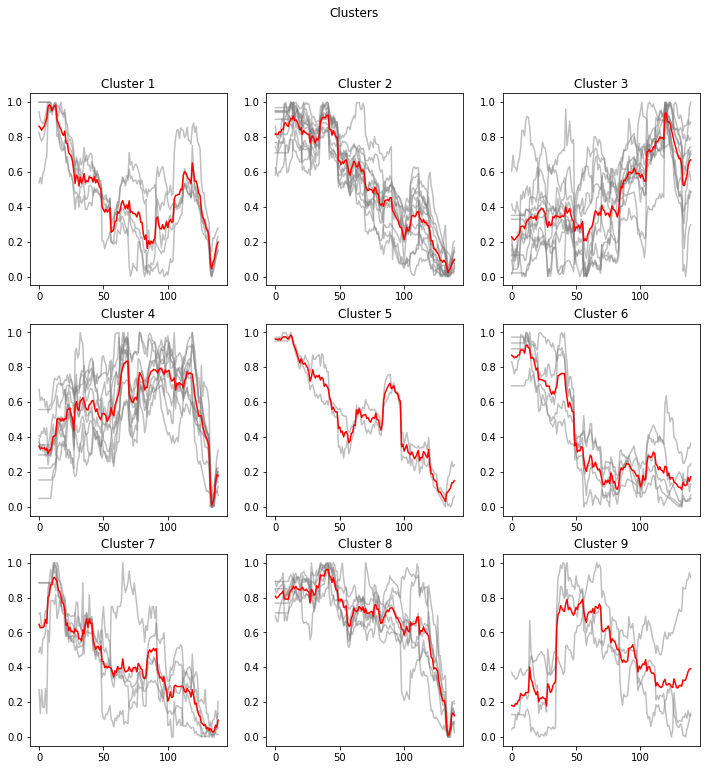

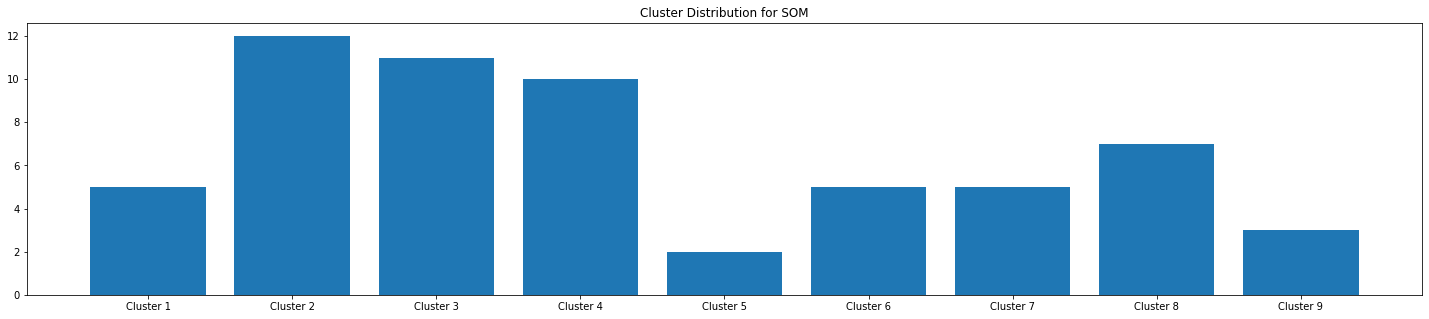

In [10]:
# Visualization
visualize_clusters(som_x, som_y, win_map)

# Train the DQN Model

The code needs three positional parameters to be correctly executed: \\
python main.py [numberOfActions, isOnlyShort, ensembleFolder]


* To run the FULL agent you need to run: python main.py 3 0 ensembleFolder
* To run the ONLY LONG agent you need to run: python main.py 2 0 ensembleFolder
* To run the ONLY SHORT agent you need to run: python main.py 2 1 ensembleFolder \\
where the paramenter ensembleFolder is used to set the name of the folder in which you'll get your results.

In [ ]:
"""This is the class call for the Agent which will perform the experiment"""

#This is the class call for the Agent which will perform the experiment
from deepQTrading import DeepQTrading

#Date library to manipulate time in the source code
import datetime

#Keras library to define the NN to be used
from keras.models import Sequential

#Layers used in the NN considered
from keras.layers import Dense, Activation, Flatten

#Activation Layers used in the source code
from keras.layers.advanced_activations import LeakyReLU, PReLU, ReLU

#Optimizer used in the NN
from keras.optimizers import Adam

#Libraries used for the Agent considered
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy


#Library used for showing the exception in the case of error 
import sys

import pandas as pd
import numpy as np
from evaluation import perc_ensemble, full_ensemble

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

'''
There are three actions possible in the stock market
Hold(id 0): do nothing.
Long(id 1): It predicts that the stock market value will raise at the end of the day. 
So, the action performed in this case is buying at the beginning of the day and sell it at the end of the day (aka long).
Short(id 2): It predicts that the stock market value will decrease at the end of the day.
So, the action that must be done is selling at the beginning of the day and buy it at the end of the day (aka short). 
//////////////////////////////////////////////////////////////
The Model is a simple NN considered. It is composed of:
One flatten layer to get 68 dimensional vectors as input
One dense layer with 35 neurons and LeakyRelu activation
One final Dense Layer with the 3 actions considered
the input is 20 observation days from the past, 8 observations from the past week and 
40 observations from the past hours
//////////////////////////////////////////////////////////////
Define the DeepQTrading class with the following parameters:
explorations: 0.2 operations are random, and 100 epochs.
in this case, epochs parameter is used because the Agent acts on daily basis, so its better to repeat the experiments several
times so, its defined that each epoch will work on the data from training, validation and testing.
trainSize: the size of the train data gotten from the dataset, we are setting 5 stock market years, or 1800 days
validationSize: the size of the validation data gotten from dataset, we are setting 6 stock market months, or 180 days
testSize: the size of the testing data gotten from dataset, we are setting 6 stock market months, or 180 days
outputFile: where the results will be written
begin: where the walks will start from. We are defining January 1st of 2010
end: where the walks will finish. We are defining February 22nd of 2019
nOutput:number of walks
'''
# Set Parameters
nb_actions = 2
isOnlyShort = 1
ensembleFolderName = "ensembleFolder"
# ticker = "AAPL"

# Define the model 
model = Sequential()
model.add(Flatten(input_shape=(1, 1, 68)))
model.add(Dense(35, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

stocks = ['AAPL']
for ticker in stocks:

    # Define the DeepQTrading class
    dqt = DeepQTrading(
        ticker=ticker,
        model=model,
        explorations=[(0.2, 10)],
        trainSize=datetime.timedelta(days=30*8),
        validationSize=datetime.timedelta(days=30*1),
        testSize=datetime.timedelta(days=30*1),
        outputFile="Output/csv/walks/walks",
        begin=datetime.datetime(2020, 6, 30, 0, 0, 0, 0),
        end=datetime.datetime(2022, 4, 1, 0, 0, 0, 0),
        nbActions=nb_actions,
        isOnlyShort=isOnlyShort,
        ensembleFolderName=ensembleFolderName
        )
    numwalks = dqt.run()
    dqt.end()

    # Preparing and saving the results
    numDel = 0
    for j in range(0, numwalks):
        df = pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+"ensemble_test.csv", index_col='Date')

        for deleted in range(1, numDel):
            del df['iteration'+str(deleted)]
        
        if j == 0:
            fulldf = perc_ensemble(df)
        else:
            fulldf = fulldf.append(perc_ensemble(df))

    # Save results
    PATH = "./Output/results/"
    method = "short" if isOnlyShort == 1 else "long"
    fulldf.to_csv(f"{PATH}{ticker}_{method}.csv")

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Resetted: episode 161; Index 1149 over the limit (1149)
0 TRAIN:  acc: 0.36666666666666664 cov: 0.15625 rew: -0.09013031191108282
Resetted: episode 18; Index 153 over the limit (153)
0 VALID:  acc: 0.25 cov: 0.16666666666666666 rew: -0.04032648431153789
Resetted: episode 17; Index 146 over the limit (146)
0 TEST:  acc: 0.5 cov: 0.16666666666666666 rew: -0.0021115165818192706
 
Resetted: episode 161; Index 1149 over the limit (1149)
1 TRAIN:  acc: 0.5681818181818182 cov: 0.22916666666666666 rew: 0.14739327209928377
Resetted: episode 18; Index 153 over the limit (153)
1 VALID:  acc: 0.25 cov: 0.16666666666666666 rew: -0.04032648431153789
Resetted: episode 17; Index 146 over the limit (146)
1 TEST:  acc: 0.5 cov: 0.16666666666666666 rew: -0.0021115165818192706
 
Resetted: episode 161; Index 1149 over the limit (1149)
2 TRAIN:  acc: 0.5128205128205128 cov: 0.203125 rew: 0.02671399414296602
Resetted: episode 18; Index 153 over the limit (153)
2 VALID:  acc: 0.25 cov: 0.16666666666666666 rew

In [ ]:
def ensemble(numWalks, ticker, data_type='test', numDel=0):
    dollSum=0
    rewSum=0
    posSum=0
    negSum=0
    covSum=0
    numSum=0

    values=[]
    #output=open("daxValidDel9th60.csv","w+")
    #output.write("Iteration,Reward%,#Wins,#Losses,Euro,Coverage,Accuracy\n")
    columns = ["Iteration","Reward%","#Wins","#Losses","Dollars","Coverage","Accuracy"]
    dax=pd.read_csv(f"./datasets/{ticker}day.csv", index_col='Date')
    for j in range(0, numWalks):

        df=pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+"ensemble_"+data_type+".csv",index_col='Date')



        for deleted in range(1,numDel):
            del df['iteration'+str(deleted)]
        
        df = perc_ensemble(df)

        num=0
        rew=0
        pos=0
        neg=0
        doll=0
        cov=0
        for date, i in df.iterrows():
            num+=1

            if date in dax.index:
                if (i['ensemble']==1):
                    pos+= 1 if (dax.at[date,'Close']-dax.at[date,'Open'])/dax.at[date,'Open'] > 0 else 0
                    
                    neg+= 0 if (dax.at[date,'Close']-dax.at[date,'Open'])/dax.at[date,'Open'] > 0 else 1
                    rew+=(dax.at[date,'Close']-dax.at[date,'Open'])/dax.at[date,'Open']
                    doll+=(dax.at[date,'Close']-dax.at[date,'Open'])*50
                    cov+=1
                elif (i['ensemble']==2):
                    
                    neg+= 0 if -(dax.at[date,'Close']-dax.at[date,'Open'])/dax.at[date,'Open'] > 0 else 1
                    pos+= 1 if -(dax.at[date,'Close']-dax.at[date,'Open'])/dax.at[date,'Open'] > 0 else 0
                    rew+=-(dax.at[date,'Close']-dax.at[date,'Open'])/dax.at[date,'Open']
                    cov+=1
                    doll+=-(dax.at[date,'Close']-dax.at[date,'Open'])*50
        
        values.append([str(round(j,2)),str(round(rew,2)),str(round(pos,2)),str(round(neg,2)),str(round(doll,2)),str(round(cov/num,2)),(str(round(pos/cov,2)) if (cov>0) else "")])
        
        dollSum+=doll
        rewSum+=rew
        posSum+=pos
        negSum+=neg
        covSum+=cov
        numSum+=num


    values.append(["sum",str(round(rewSum,2)),str(round(posSum,2)),str(round(negSum,2)),str(round(dollSum,2)),str(round(covSum/numSum,2)),(str(round(posSum/covSum,2)) if (covSum>0) else "")])
    
    columns = ["Iteration","Reward%","#Wins","#Losses","Dollars","Coverage","Accuracy"]
    result = {'Iteration':values[0], 'Reward%':values[1],
              '#Wins':values[2]}

    return pd.DataFrame(values, columns= columns)

In [ ]:

res = ensemble(numWalks=numwalks, ticker=stocks[0])
res

,Iteration,Reward%,#Wins,#Losses,Dollars,Coverage,Accuracy
0,0,0.02,9,7,8.0,0.76,0.56
1,1,-0.06,7,9,-20.5,0.76,0.44
2,2,0.18,10,4,62.5,0.64,0.71
3,3,-0.02,4,5,-7.5,0.45,0.44
4,4,-0.06,1,7,-18.0,0.36,0.12
5,5,-0.03,7,7,-8.5,0.64,0.5
6,6,-0.0,7,9,-0.5,0.76,0.44
7,7,0.11,10,3,35.5,0.62,0.77
8,8,-0.02,4,8,-4.5,0.6,0.33
9,9,-0.03,4,6,-8.5,0.53,0.4


# Trading

In [ ]:
from Trading_Metrics import trade, metrics


# Load the Decisions
actions_long = pd.read_csv("resultEnsembleTest_Long.csv")
actions_short = pd.read_csv("resultEnsembleTest_Short.csv")
df = pd.read_csv("datasets/aaplDay.csv")
# Drop the useless columns
# df = df.reindex(columns = ['Date', 'Open', 'Close'])

In [ ]:
import numpy as np

# number of cards
n = int(input())

# get farhad card numbers
f = []
for _ in range(n):
    x = int(input())
    f.append(x)

# kianush card numbers
allnum = list(range(1,(2*n)+1))
#print(all)
k = []
for item in allnum:
    t = item
    if t not in f:
        k.append(t)

def dist(a, b):
    dis = [np.abs(i - b) for i in a]
    best = np.argmin(dis)
    best = a[best]
    return best

def balabbr(a, b):
    temp = a.copy()
    count =0
    if len(b) == 0:
        return 0
    for item in b:
        if bigger := [i for i in temp if i > item]:
            bestbig = dist(bigger,item)
            count +=1
            temp.remove(bestbig)
    return count

def paeenbrr(a, b):
    temp = a.copy()
    count =0
    if len(b) == 0:
        return 0
    for item in b:
        if smaller := [i for i in temp if i < item]:
            bestsmall = dist(smaller,item)
            count +=1
            temp.remove(bestsmall)
    return count

def score(k, f):
    max_s = n
    brep = n+1 # az koja berim paein barare
    scores = []
    for i in range(brep):
        bb = f[:i]
        bp = f[i:]
        x = balabbr(k,bb)
        y = paeenbrr(k,bp)
        s = x + y
        if s == max_s:
            return max_s
        scores.append(s)
    return np.max(scores)

print(score(k,f))